In [ ]:
import os
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
from tqdm.auto import tqdm
from sklearn.metrics import classification_report, confusion_matrix
from collections import Counter

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Define paths to your dataset
train_path = '/content/drive/My Drive/Colab Notebooks/public-data/image/dataset/train'
valid_path = '/content/drive/My Drive/Colab Notebooks/public-data/image/dataset/val'
test_path = '/content/drive/My Drive/Colab Notebooks/public-data/image/dataset/test'

def analyze_dataset(path):
    class_counts = Counter()
    for class_dir in os.listdir(path):
        class_path = os.path.join(path, class_dir)
        if os.path.isdir(class_path):
            count = len(os.listdir(class_path))
            class_counts[class_dir] = count
    return class_counts

# Data transformation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load datasets
train_ds = datasets.ImageFolder(train_path, transform=transform)
valid_ds = datasets.ImageFolder(valid_path, transform=transform)
test_ds = datasets.ImageFolder(test_path, transform=transform)

train_loader = DataLoader(train_ds, batch_size=20, shuffle=True)
valid_loader = DataLoader(valid_ds, batch_size=20, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=20, shuffle=False)

# Initialize ResNet model
model = models.resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(train_ds.classes))

# Define device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 20
patience = 3
best_loss = float('inf')
patience_counter = 0

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_corrects = 0

    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        train_corrects += torch.sum(preds == labels.data)

    train_loss = train_loss / len(train_loader.dataset)
    train_acc = train_corrects.double() / len(train_loader.dataset)
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')

    # Validation step
    model.eval()
    valid_loss = 0.0
    with torch.no_grad():
        for images, labels in valid_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            valid_loss += loss.item() * images.size(0)

    valid_loss = valid_loss / len(valid_loader.dataset)

    if valid_loss < best_loss:
        best_loss = valid_loss
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f'Early stopping triggered at epoch {epoch+1}')
            break

    print(f'Epoch {epoch+1}/{num_epochs}, Valid Loss: {valid_loss:.4f}')


Mounted at /content/drive


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:02<00:00, 36.3MB/s]


Epoch 1/20:   0%|          | 0/327 [00:00<?, ?it/s]

Epoch 1/20, Train Loss: 0.4282, Train Acc: 0.8472
Epoch 1/20, Valid Loss: 0.1470


Epoch 2/20:   0%|          | 0/327 [00:00<?, ?it/s]

Epoch 2/20, Train Loss: 0.2115, Train Acc: 0.9320
Epoch 2/20, Valid Loss: 0.1533


Epoch 3/20:   0%|          | 0/327 [00:00<?, ?it/s]

Epoch 3/20, Train Loss: 0.1389, Train Acc: 0.9515
Epoch 3/20, Valid Loss: 0.0732


Epoch 4/20:   0%|          | 0/327 [00:00<?, ?it/s]

Epoch 4/20, Train Loss: 0.0986, Train Acc: 0.9673
Epoch 4/20, Valid Loss: 0.1141


Epoch 5/20:   0%|          | 0/327 [00:00<?, ?it/s]

Epoch 5/20, Train Loss: 0.0936, Train Acc: 0.9699
Epoch 5/20, Valid Loss: 0.0282


Epoch 6/20:   0%|          | 0/327 [00:00<?, ?it/s]

Epoch 6/20, Train Loss: 0.0892, Train Acc: 0.9706
Epoch 6/20, Valid Loss: 0.0364


Epoch 7/20:   0%|          | 0/327 [00:00<?, ?it/s]

Epoch 7/20, Train Loss: 0.0784, Train Acc: 0.9755
Epoch 7/20, Valid Loss: 0.0652


Epoch 8/20:   0%|          | 0/327 [00:00<?, ?it/s]

Epoch 8/20, Train Loss: 0.0744, Train Acc: 0.9780
Early stopping triggered at epoch 8


# Performance Evaluation

In [ ]:
# Testing loop
model.eval()  # Set the model to evaluation mode
test_loss = 0.0
test_corrects = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item() * images.size(0)

        _, preds = torch.max(outputs, 1)
        test_corrects += torch.sum(preds == labels.data)

test_loss = test_loss / len(test_loader.dataset)
test_acc = test_corrects.double() / len(test_loader.dataset)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}')


Test Loss: 0.1640, Test Accuracy: 0.9363


# Confusion Matrix

Confusion Matrix:
[[179  23   0   2]
 [  2 202   0   0]
 [  0   1 203   0]
 [  1  17   6 180]]


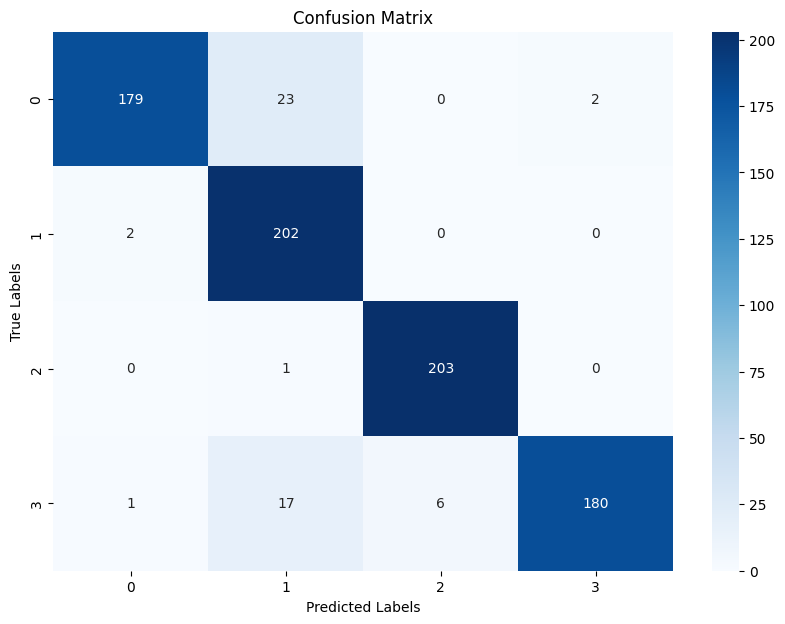

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.88      0.93       204
           1       0.83      0.99      0.90       204
           2       0.97      1.00      0.98       204
           3       0.99      0.88      0.93       204

    accuracy                           0.94       816
   macro avg       0.94      0.94      0.94       816
weighted avg       0.94      0.94      0.94       816



In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Initialize lists to store labels and predictions
all_labels = []
all_preds = []


model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)

        _, preds = torch.max(outputs, 1)

        # Extend the list of all labels and predictions
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

# Convert lists to numpy arrays for use with sklearn metrics
all_labels = np.array(all_labels)
all_preds = np.array(all_preds)

# generate the confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Printing the confusion matrix
print("Confusion Matrix:")
print(cm)

# Ensure cm is not empty before plotting
if cm.size > 0:
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

    # Generate and print classification report
    report = classification_report(all_labels, all_preds)
    print("Classification Report:")
    print(report)
else:
    print("Confusion Matrix is empty. No data to plot.")


Confusion Matrix for each classes

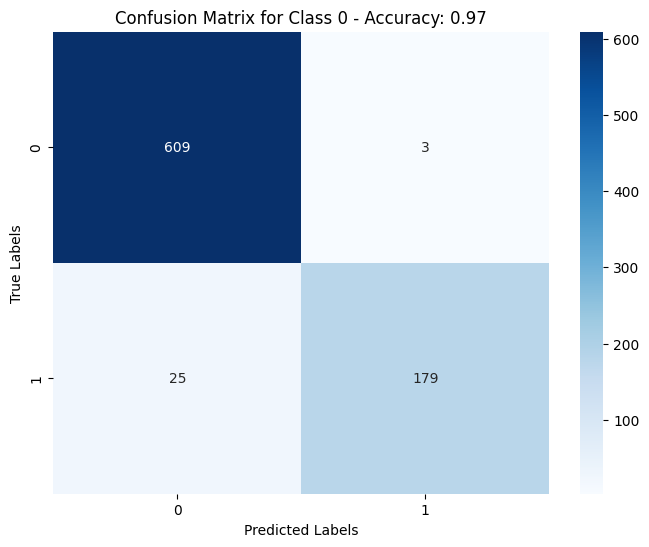

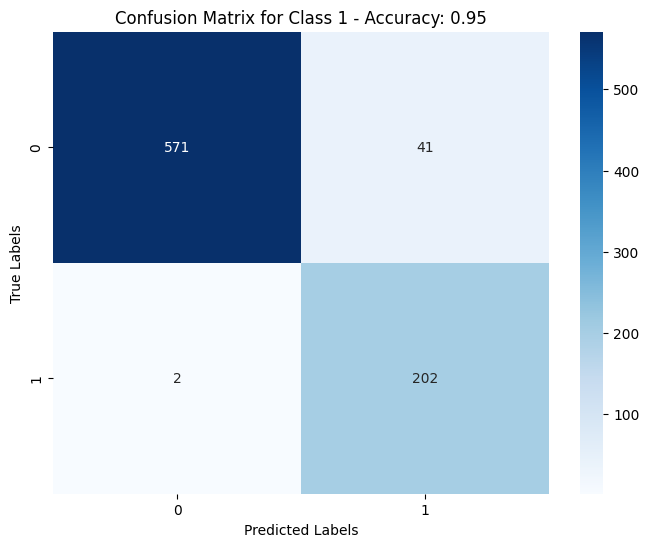

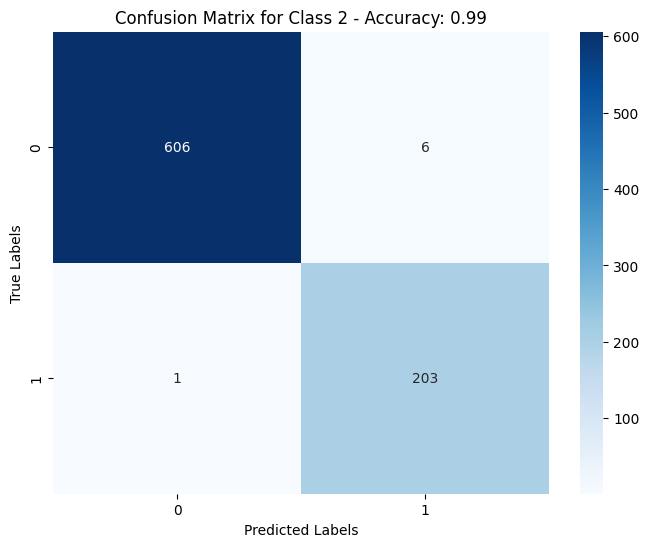

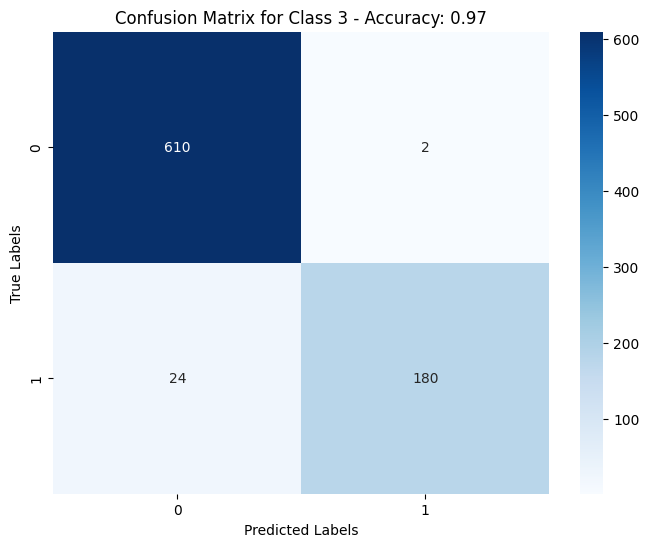

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# Function to plot the confusion matrix
def plot_confusion_matrix(cm, class_name, accuracy):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
    plt.title(f'Confusion Matrix for Class {class_name} - Accuracy: {accuracy:.2f}')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()


num_classes = 4

for i in range(num_classes):
    # Binarize labels for current class
    binarized_labels = (all_labels == i).astype(int)
    binarized_preds = (all_preds == i).astype(int)

    # Compute confusion matrix
    cm = confusion_matrix(binarized_labels, binarized_preds)

    # Calculate accuracy
    accuracy = (cm[0, 0] + cm[1, 1]) / cm.sum()

    # Plot confusion matrix
    plot_confusion_matrix(cm, class_name=str(i), accuracy=accuracy)




# Roc-Auc

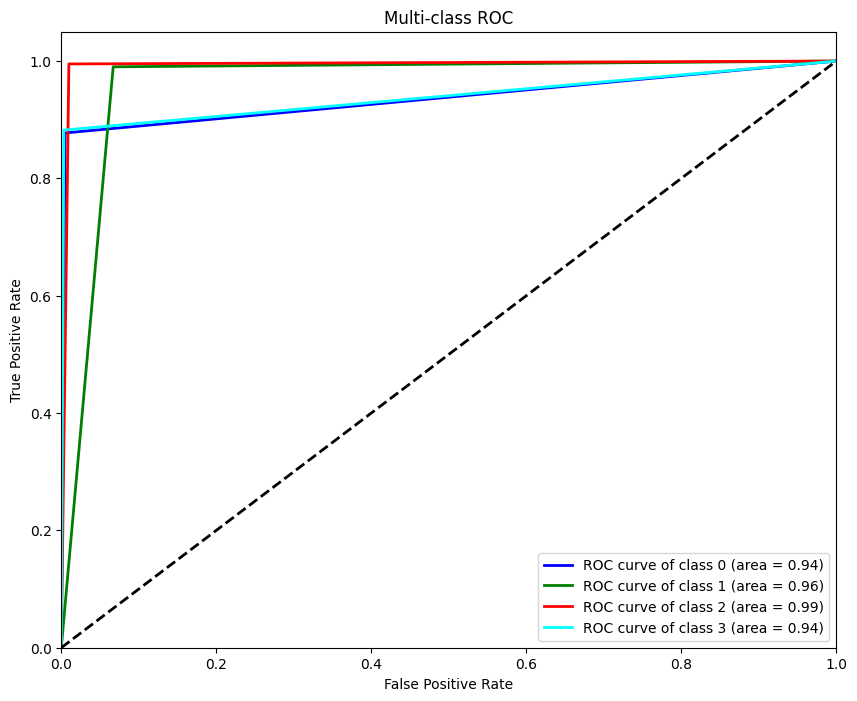

In [ ]:
import numpy as np
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.preprocessing import label_binarize
from keras.utils import to_categorical

# Convert class indices to one-hot encoded format
all_preds_one_hot = to_categorical(all_preds, num_classes=num_classes)

# Binarize labels
all_labels_binarized = label_binarize(all_labels, classes=range(num_classes))

# Proceed with ROC curve calculation
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(all_labels_binarized[:, i], all_preds_one_hot[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plotting
plt.figure(figsize=(10, 8))
lw = 2  # Line width
colors = cycle(['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black', 'pink', 'lightgreen', 'lightblue'])
for i, color in zip(range(num_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC')
plt.legend(loc="lower right")
plt.show()
